In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import tqdm
from itertools import cycle

%matplotlib  inline

In [ ]:
from google.colab import drive

if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')

In [ ]:
# Calculate accuracy for a batch
def test_batch(model, inputs, labels, device):
    model.to(device)
    model.eval()

    total = labels.size(0)  # Number of samples in the batch

    with torch.no_grad():
        outputs = model(inputs)
        predicted = labeling(outputs).reshape(-1,)
        correct = torch.sum(predicted == labels).item()

    acc = 100 * correct / total

    return acc

# Calculate accuracy for whole data
def test (model, test_data, device):

    model.to(device)
    model.eval()

    correct = 0
    total = 0

    data  = iter(test_data)
    with torch.no_grad():

        # for _ in tqdm.trange(len(test_data)):
        for _ in range(len(test_data)):
            inputs, labels = next(data)
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            predicted = labeling(outputs)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100*correct/total

    return acc

# Labeling from logits to
def labeling(array):

    label = torch.where(array>=0.5,1,0)
    return label

# It will set parameters.requires_grad to true or false
def set_grad(model, does=True):
    for param in model.parameters():
        param.requires_grad = does

# Evaluate outputs of the model
def model_eval(model, data_loader):
    features = []
    outputs = []
    loader = iter(data_loader)
    for _ in tqdm.trange(len(data_loader)):

        input,target = next(loader)
        # Extract features
        feature = model.extract(input)
        # Classify features
        output = model.classifier(feature)
        # Save all
        features.append(feature)
        outputs.append(output)

    # To torch tnesor
    features = torch.stack(features,dim=0).squeeze()
    outputs = torch.stack(outputs, dim=0)

    return features, outputs


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data

In [ ]:
project_path = '/content/drive/MyDrive/ML_Aliyari/Project'

# Read data
df_s = pd.read_csv(os.path.join(project_path,'Source.csv'))
df_t = pd.read_csv(os.path.join(project_path,'Target.csv'))

In [ ]:

# Source data
X_s = df_s.iloc[:,2:].values
y_s = np.array([int(name.split('_')[-1])for name in df_s.name.values])
# Target data
X_t = df_t.iloc[:,2:].values
y_t = np.array([int(name.split('_')[-1])for name in df_t.name.values])



Prepare data for a sequential model

shape --> (#,100,9)

In [ ]:
# Source data
sequence_length = 100
stride = 50
n_samples = (500 - sequence_length)/stride + 1
X_s_sequences = np.zeros(shape=(400,sequence_length,int(n_samples)))
y_s_sequences = []

for i in range(len(X_s)):
    signal = X_s[i,:]
    label = y_s[i]
    k = 0
    for j in range(0,len(signal) - sequence_length + 1,stride):
            sequence = signal[j:j + sequence_length]
            # X_train_sequences.append(sequence)
            X_s_sequences[i,:,k] = sequence
            k += 1
    y_s_sequences.append(label)
y_s_sequences = np.array(y_s_sequences)
# Target data
sequence_length = 100
stride = 50
n_samples = (500 - sequence_length)/stride + 1
X_t_sequences = np.zeros(shape=(200,sequence_length,int(n_samples)))
y_t_sequences = []

for i in range(len(X_t)):
    signal = X_t[i,:]
    label = y_t[i]
    k = 0
    for j in range(0,len(signal) - sequence_length + 1,stride):
            sequence = signal[j:j + sequence_length]
            # X_train_sequences.append(sequence)
            X_t_sequences[i,:,k] = sequence
            k += 1
    y_t_sequences.append(label)
y_t_sequences = np.array(y_t_sequences)

## Train main model

### Preprocess

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Splitting
x_s_train, x_s_test, y_s_train, y_s_test = train_test_split(X_s_sequences, y_s_sequences, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
print('Source data properties:')
print(f'X_train shape: {x_s_train.shape}')
print(f'x_test shape: {x_s_test.shape}')
print(f'y_train shape: {y_s_train.shape}')
print(f'y_test shape: {y_s_test.shape}')

Source data properties:
X_train shape: (320, 100, 9)
x_test shape: (80, 100, 9)
y_train shape: (320,)
y_test shape: (80,)


In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
x_s_train_scaled = scaler.fit_transform(x_s_train.reshape(-1, x_s_train.shape[-1])).reshape(x_s_train.shape)
x_s_test_scaled = scaler.transform(x_s_test.reshape(-1, x_s_test.shape[-1])).reshape(x_s_test.shape)
x_s = scaler.transform(X_s_sequences.reshape(-1,X_s_sequences.shape[-1])).reshape(X_s_sequences.shape)

In [ ]:
print('Properties of scaled data:')
print(f'X_train shape: {x_s_train_scaled.shape}')
print(f'x_test shape: {x_s_test_scaled.shape}',end='\n\n')
print(f'Scaled max: {x_s_train_scaled.max()}')
print(f'Non-Scaled max: {x_s_train.max()}')

Properties of scaled data:
X_train shape: (320, 100, 9)
x_test shape: (80, 100, 9)

Scaled max: 2.9023424580100015
Non-Scaled max: 0.0796803573286535


### LSTM network

In [ ]:
## TENSORFLOW code

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

# Define the LSTM network architecture
model = Sequential()
model.add(LSTM(128,return_sequences=True, input_shape=(100,9,)))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(8,return_sequences=False))
model.add(Dense(8,activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Assuming you have a binary classification task

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Train the model
model.fit(x_s_train_scaled, y_s_train, epochs=20, batch_size=32, validation_data=(x_s_test_scaled,y_s_test))

In [ ]:
print(model)

LSTMModel(
  (feature_extraction): Sequential(
    (0): LSTM(9, 128, batch_first=True)
    (1): LSTM(128, 128, batch_first=True)
    (2): LSTM(128, 64, batch_first=True)
    (3): LSTM(64, 16, batch_first=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [ ]:
# Define the LSTM network architecture
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()

        # Feature Extraction Layers
        self.feature_extraction = nn.Sequential(
            nn.LSTM(input_size=9, hidden_size=128, batch_first=True),
            nn.LSTM(input_size=128, hidden_size=128, batch_first=True),
            nn.LSTM(input_size=128, hidden_size=64, batch_first=True),
            nn.LSTM(input_size=64, hidden_size=16, batch_first=True)
        )

        # Classifier Layers
        self.classifier = nn.Sequential(
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

        # Training-related attributes
        self.best_acc = 0
        self.save_path = '/content/drive/MyDrive/ML_Aliyari/Project/lstm_weights.pth'
        self.patience = 5

    def forward(self, x):
        # Feature Extraction
        # for lstm in self.feature_extraction:
        #     x, _ = lstm(x)
        # x = x[:, -1, :]  # get the output of the last time step
        x = self.extract(x)

        # Classification
        x = self.classifier(x)

        return x

    # Function for Early Stopping
    def early_stopping(self,val_acc, **kwargs):

        '''
        Incase you wanted to use best loss
        just use "-loss" instead of val_acc

        '''
        # Early stopping
        if val_acc > self.best_acc:

            self.best_acc = val_acc
            self.best_epoch = epoch
            self.current_patience = 0

            # Save the model's weights
            torch.save(self.state_dict(), self.save_path)
            return False
        else:
            self.current_patience += 1
            # Check if the patience limit is reached
            if self.current_patience >= self.patience:
                print("Early stopping triggered!")
                return True

    def extract(self,x):
        # Feature Extraction
        for lstm in self.feature_extraction:
            x, _ = lstm(x)
        x = x[:, -1, :]  # get the output of the last time step
        return x

# Create the model instance
model = LSTMModel().to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Prepare data for torch model
batch_size = 32
#

In [ ]:

train_data = torch.utils.data.TensorDataset(torch.tensor(x_s_train_scaled, dtype=torch.float32),
                                            torch.tensor(y_s_train, dtype=torch.float32))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
#
train_loader_2 = torch.utils.data.DataLoader(train_data, shuffle=False)
#
test_data = torch.utils.data.TensorDataset(torch.tensor(x_s_test_scaled, dtype=torch.float32),
                                            torch.tensor(y_s_test, dtype=torch.float32))
test_loader = torch.utils.data.DataLoader(test_data, shuffle=False)

#### Train the model

In [ ]:
# Training the model
num_epochs = 60

best_accuracy = 0
loss_list = []
val_acc_list  = []
train_acc_list = []
for epoch in range(num_epochs):
    model.train()
    pbar = tqdm.tqdm(
        enumerate(train_loader),
        total=len(train_loader),
        desc=f'Epoch {epoch+1}/{num_epochs}',
        position=0, leave=True
    )
    acc_list = []
    for i,(inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        pred = labeling(outputs).reshape(-1,)
        cor = torch.sum(pred==labels).item()
        acc = cor / labels.shape[0] * 100
        acc_list.append(acc)

        pbar.set_description(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {np.mean(acc_list):.2f}')

    # Calculate validation accuracy
    val_acc = test(model,test_loader, device)
    val_acc_list.append(val_acc)
    print(f'Test accuracy is: {val_acc:0.2f}')



    train_acc_list.append(np.mean(acc_list))
    loss_list.append(loss.cpu().detach().numpy())

    # Early Stopping
    do_break = model.early_stopping(val_acc)
    if do_break:
        break





Epoch 1/60, Loss: 0.6827, Accuracy: 48.75: 100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Test accuracy is: 55.00


Epoch 2/60, Loss: 0.6430, Accuracy: 70.00: 100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


Test accuracy is: 83.75


Epoch 3/60, Loss: 0.6064, Accuracy: 81.25: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


Test accuracy is: 82.50


Epoch 4/60, Loss: 0.5995, Accuracy: 81.56: 100%|██████████| 10/10 [00:01<00:00,  5.04it/s]


Test accuracy is: 83.75


Epoch 5/60, Loss: 0.5843, Accuracy: 80.31: 100%|██████████| 10/10 [00:01<00:00,  5.07it/s]


Test accuracy is: 83.75


Epoch 6/60, Loss: 0.5679, Accuracy: 81.56: 100%|██████████| 10/10 [00:01<00:00,  5.09it/s]


Test accuracy is: 83.75


Epoch 7/60, Loss: 0.5297, Accuracy: 81.88: 100%|██████████| 10/10 [00:02<00:00,  4.88it/s]


Test accuracy is: 82.50
Early stopping triggered!


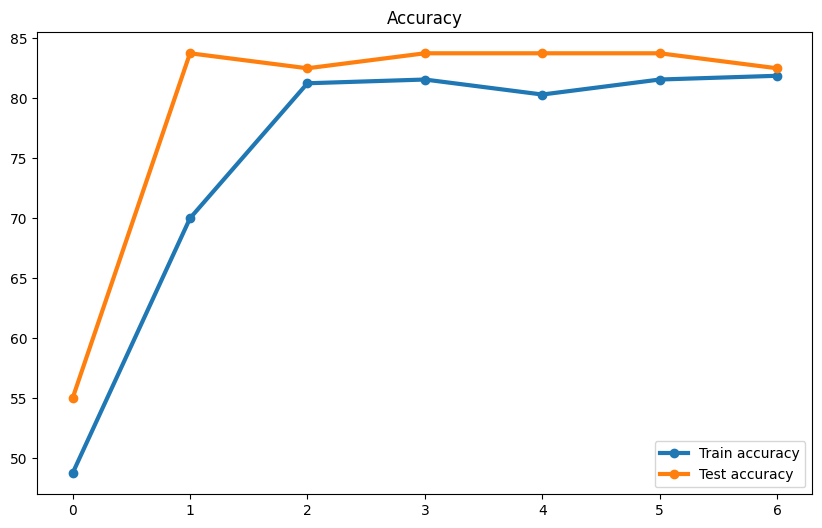

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_acc_list, label='Train accuracy', linewidth=3, marker='o')
plt.plot(val_acc_list, label='Test accuracy', linewidth=3, marker='o')
plt.title('Accuracy')
plt.legend()

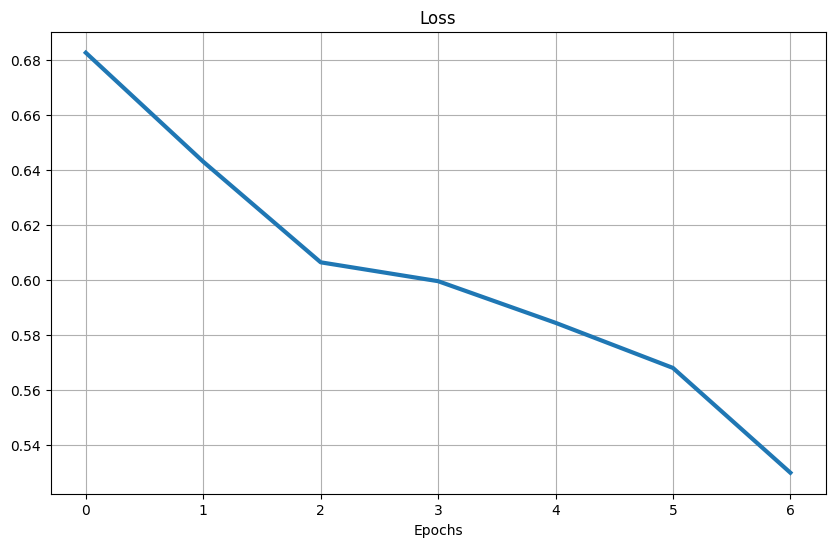

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(loss_list, linewidth=3)
plt.title('Loss')
plt.xlabel('Epochs')
plt.grid()

In [ ]:
print(f'Best Train accuracy: {train_acc_list[-1]:.1f}%')
print(f'Best Validation accuracy: {val_acc_list[-1]:.1f}%')
print(f'The best epoch is {model.best_epoch+1}')

Best Train accuracy: 81.9%
Best Validation accuracy: 82.5%
The best epoch is 2


## Discriminator

### Target preprocess

In [ ]:
# Splitting
x_t_train, x_t_test, y_t_train, y_t_test = train_test_split(X_t_sequences, y_t_sequences, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
print('Source data properties:')
print(f'X_train shape: {x_t_train.shape}')
print(f'x_test shape: {x_t_test.shape}')
print(f'y_train shape: {y_t_train.shape}')
print(f'y_test shape: {y_t_test.shape}')

Source data properties:
X_train shape: (160, 100, 9)
x_test shape: (40, 100, 9)
y_train shape: (160,)
y_test shape: (40,)


In [ ]:
scaler = StandardScaler()
x_t_train_scaled = scaler.fit_transform(x_t_train.reshape(-1, x_t_train.shape[-1])).reshape(x_t_train.shape)
x_t_test_scaled = scaler.transform(x_t_test.reshape(-1, x_t_test.shape[-1])).reshape(x_t_test.shape)
x_t = scaler.transform(X_t_sequences.reshape(-1,X_t_sequences.shape[-1])).reshape(X_t_sequences.shape)

In [ ]:
print('Properties of scaled data:')
print(f'X_train shape: {x_s_train_scaled.shape}')
print(f'x_test shape: {x_s_test_scaled.shape}',end='\n\n')
print(f'Scaled max: {x_s_train_scaled.max()}')
print(f'Non-Scaled max: {x_s_train.max()}')

Properties of scaled data:
X_train shape: (320, 100, 9)
x_test shape: (80, 100, 9)

Scaled max: 2.9023424580100015
Non-Scaled max: 0.0796803573286535


### Train discriminator

In [ ]:
import copy

In [ ]:
source_model = LSTMModel().to(device)
source_model.load_state_dict(torch.load(source_model.save_path)) # Loading weights
source_model.eval()
set_grad(source_model,False)

source_clone = copy.deepcopy(source_model)
source_model = source_model.feature_extraction

target_model = LSTMModel().to(device)
# target_model.load_state_dict(torch.load(target_model.save_path)) # Load model weights
target_model = target_model.feature_extraction


BATCH_SIZE = 40
hb = BATCH_SIZE//2
LEARNING_RATE = 0.001

# Discriminator network
discri = nn.Sequential(
    nn.Linear(16,8),
    nn.ReLU(),
    nn.Linear(8,1),
    nn.Sigmoid()
).to(device)

# Loading data
# Source
source_data = torch.utils.data.TensorDataset(torch.tensor(x_s, dtype=torch.float32),
                                            torch.tensor(y_s_sequences, dtype=torch.float32))
source_loader = torch.utils.data.DataLoader(source_data, batch_size=hb, shuffle=False)
# Target Train
target_train_data = torch.utils.data.TensorDataset(torch.tensor(x_t_train_scaled, dtype=torch.float32),
                                            torch.tensor(y_t_train, dtype=torch.float32))
target_train_loader = torch.utils.data.DataLoader(target_train_data, batch_size=hb, shuffle=False)
# Target test
target_test_data = torch.utils.data.TensorDataset(torch.tensor(x_t_test_scaled, dtype=torch.float32),
                                            torch.tensor(y_t_test, dtype=torch.float32))
target_test_loader = torch.utils.data.DataLoader(target_test_data, batch_size=hb, shuffle=False)

discri_optim = optim.Adam(discri.parameters(), lr=LEARNING_RATE)
target_optim = optim.Adam(target_model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()


In [ ]:
# Train
N_EPOCHS = 30
iterations = 100
disc_iter = 1
targ_iter = 15
best_accuracy = 0
td_loss_list = []
td_acc_list  = []
old_dict = target_model.state_dict()

for epoch in range(1,N_EPOCHS+1):

    batch_iterator = zip(cycle(source_loader), cycle(target_train_loader))

    for _ in tqdm.trange(iterations,leave=False):

        # Setting trainable and untrainable models
        set_grad(target_model,False)
        set_grad(discri,True)


        total_loss = 0
        total_acc = 0

        # Train discriminator
        for _ in range(disc_iter):

            # Load inputs
            (source_x,_), (target_x,_) = next(batch_iterator)
            source_x, target_x = source_x.to(device), target_x.to(device)

            # Feature FP
            source_feature = source_x.clone()
            for l in source_model:
                source_feature,_ = l(source_feature)
            source_feature = source_feature[:, -1, :]

            target_feature = target_x.clone()
            for l in target_model:
                target_feature,_ = l(target_feature)
            target_feature = target_feature[:, -1, :]

            discri_x = torch.cat([source_feature, target_feature], dim=0)
            discri_y = torch.cat(
                [
                    torch.ones(source_x.shape[0], dtype=torch.float32, device=device),
                    torch.zeros(target_x.shape[0], dtype=torch.float32, device=device)
                ]
            )

            preds = discri(discri_x).squeeze()
            loss = criterion(preds, discri_y)

            discri_optim.zero_grad()
            loss.backward()
            discri_optim.step()

            total_loss += loss.item()
            # They all should become ones
            total_acc += ((preds>0.5).long() == discri_y.long()).float().mean()

        set_grad(target_model, True)
        set_grad(discri, False)

        for _ in range(targ_iter):
            # Load inputs
            _, (target_x,_) = next(batch_iterator)
            target_x = target_x.to(device)

            # Feature FP
            target_feature = target_x.clone()
            for l in target_model:
                target_feature,_ = l(target_feature)
            target_feature = target_feature[:, -1, :]

            discrit_y = torch.ones(target_x.shape[0], dtype=torch.float32, device=device)

            predss = discri(target_feature).squeeze()
            loss = criterion(predss, discrit_y)

            target_optim.zero_grad()
            loss.backward()
            target_optim.step()

    mean_loss = total_loss / iterations
    mean_acc = total_acc / iterations

    td_loss_list.append(mean_loss)
    td_acc_list.append(mean_acc)

    tqdm.tqdm.write(f'Epoch {epoch}/{N_EPOCHS}, Loss: {mean_loss:.4f}, Accuracy: {mean_acc:.2f}')
    new_dict = target_model.state_dict()
    old_dict = new_dict.copy()
    source_clone.feature_extraction = target_model
    torch.save(source_clone.state_dict(), '/content/drive/MyDrive/ML_Aliyari/Project/target_model.pt')






Epoch 1/30, Loss: 0.7147, Accuracy: 0.01


Epoch 2/30, Loss: 0.6924, Accuracy: 0.01


Epoch 3/30, Loss: 0.7199, Accuracy: 0.00


Epoch 4/30, Loss: 0.6944, Accuracy: 0.01


Epoch 5/30, Loss: 0.6830, Accuracy: 0.01


Epoch 6/30, Loss: 0.6807, Accuracy: 0.01


Epoch 7/30, Loss: 0.6791, Accuracy: 0.01


Epoch 8/30, Loss: 0.6777, Accuracy: 0.01


Epoch 9/30, Loss: 0.6766, Accuracy: 0.01


Epoch 10/30, Loss: 0.6756, Accuracy: 0.01


Epoch 11/30, Loss: 0.6747, Accuracy: 0.01


Epoch 12/30, Loss: 0.6738, Accuracy: 0.01


Epoch 13/30, Loss: 0.6731, Accuracy: 0.01


Epoch 14/30, Loss: 0.6725, Accuracy: 0.01


Epoch 15/30, Loss: 0.6646, Accuracy: 0.01


Epoch 16/30, Loss: 0.6629, Accuracy: 0.01


Epoch 17/30, Loss: 0.6623, Accuracy: 0.01


Epoch 18/30, Loss: 0.6621, Accuracy: 0.01


Epoch 19/30, Loss: 0.6620, Accuracy: 0.01


Epoch 20/30, Loss: 0.6619, Accuracy: 0.01


Epoch 21/30, Loss: 0.6619, Accuracy: 0.01


Epoch 22/30, Loss: 0.6619, Accuracy: 0.01


Epoch 23/30, Loss: 0.6619, Accuracy: 0.01


Epoch 24/30, Loss: 0.6618, Accuracy: 0.01


Epoch 25/30, Loss: 0.6618, Accuracy: 0.01


Epoch 26/30, Loss: 0.6618, Accuracy: 0.01


Epoch 27/30, Loss: 0.6618, Accuracy: 0.01


Epoch 28/30, Loss: 0.6618, Accuracy: 0.01


Epoch 29/30, Loss: 0.6618, Accuracy: 0.01


Epoch 30/30, Loss: 0.6618, Accuracy: 0.01


In [ ]:
print('The output of the discriminator:')
print(predss.cpu().detach().numpy())

The output of the discriminator:
[0.00024258 0.00024259 0.00024264 0.0002426  0.0002426  0.00024263
 0.00024264 0.00024263 0.00024269 0.00024261 0.00024261 0.00024265
 0.00024261 0.00024261 0.00024261 0.00024263 0.00024258 0.00024263
 0.00024256 0.00024263]


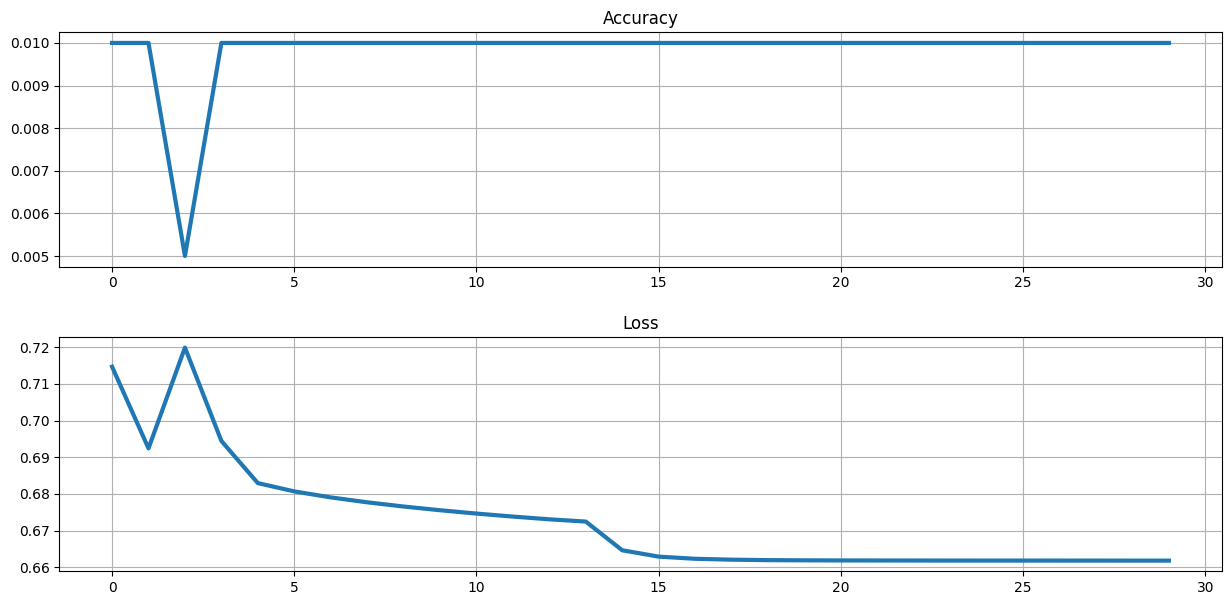

In [ ]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,7))

ax1.plot([i.cpu().detach().numpy() for i in td_acc_list],
         linewidth = 3)
ax1.set_title('Accuracy')
ax1.grid()

ax2.plot(td_loss_list,
         linewidth = 3)
ax2.set_title('Loss')
ax2.grid()

plt.subplots_adjust(hspace=0.3)

## Evaluation

Import model weights

In [ ]:
# Source model
source_model = LSTMModel().to(device)
source_model.load_state_dict(torch.load(source_model.save_path)) # Loading weights
source_model.eval();

# Target model
target_model = LSTMModel().to(device)
target_model.save_path = '/content/drive/MyDrive/ML_Aliyari/Project/target_model.pt'
target_model.load_state_dict(torch.load(target_model.save_path, map_location=torch.device('cpu'))) # Loading weights
target_model.eval();

Import data

In [ ]:
# Loading data
# Source train
source_train_data = torch.utils.data.TensorDataset(torch.tensor(x_s_train_scaled, dtype=torch.float32),
                                            torch.tensor(y_s_train, dtype=torch.float32))
source_train_loader = torch.utils.data.DataLoader(source_train_data, shuffle=False)
# Source test
source_test_data = torch.utils.data.TensorDataset(torch.tensor(x_s_test_scaled, dtype=torch.float32),
                                            torch.tensor(y_s_test, dtype=torch.float32))
source_test_loader = torch.utils.data.DataLoader(source_test_data, shuffle=False)
# Target Train
target_train_data = torch.utils.data.TensorDataset(torch.tensor(x_t_train_scaled, dtype=torch.float32),
                                            torch.tensor(y_t_train, dtype=torch.float32))
target_train_loader = torch.utils.data.DataLoader(target_train_data, shuffle=False)
# Target test
target_test_data = torch.utils.data.TensorDataset(torch.tensor(x_t_test_scaled, dtype=torch.float32),
                                            torch.tensor(y_t_test, dtype=torch.float32))
target_test_loader = torch.utils.data.DataLoader(target_test_data, shuffle=False)

In [ ]:
# Source test
stf, sto = model_eval(source_model, source_test_loader)
stf = stf.detach().numpy()
sto =  sto.detach().numpy()

# Target test
ttf, tto = model_eval(target_model, target_test_loader)
ttf = ttf.detach().numpy()
tto = tto.detach().numpy()


100%|██████████| 40/40 [00:00<00:00, 134.60it/s]


### Target Performance

In [ ]:
# Performace on source model
source_acc_test = test(source_model, target_test_loader, device)
source_acc_train = test(source_model, target_train_loader, device)

# Performace on target model
target_acc_test = test(target_model, target_test_loader, device)
target_acc_train = test(target_model, target_train_loader, device)

In [ ]:
print('MODEL ACCURACIES ON TARGET DATA')
print(f'Source model & Train data: {source_acc_train:.1f}%')
print(f'Source model & Testn data: {source_acc_test:.1f}%')
print(f'Target model & Train data: {target_acc_train:.1f}%')
print(f'Target model & Test data: {target_acc_test:.1f}%')

MODEL ACCURACIES ON TARGET DATA
Source model & Train data: 75.6%
Source model & Testn data: 80.0%
Target model & Train data: 50.6%
Target model & Test data: 47.5%


### Source Performances

In [ ]:
# Performace on source model
source_acc_test = test(source_model, source_test_loader, device)
source_acc_train = test(source_model, source_train_loader, device)

# Performace on target model
target_acc_test = test(target_model, source_test_loader, device)
target_acc_train = test(target_model, source_train_loader, device)

In [ ]:
print('MODEL ACCURACIES ON SOURCE DATA')
print(f'Source model & Train data: {source_acc_train:.1f}%')
print(f'Source model & Testn data: {source_acc_test:.1f}%')
print(f'Target model & Train data: {target_acc_train:.1f}%')
print(f'Target model & Test data: {target_acc_test:.1f}%')

MODEL ACCURACIES ON SOURCE DATA
Source model & Train data: 81.9%
Source model & Testn data: 83.8%
Target model & Train data: 51.2%
Target model & Test data: 45.0%


### Visualization

Dimention
 reduction

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne_s2 = TSNE(n_components=2, random_state=69)
tsne_s3 = TSNE(n_components=3, random_state=69)
tsne_t2 = TSNE(n_components=2, random_state=69)
tsne_t3 = TSNE(n_components=3, random_state=69)

In [ ]:
stf2 = tsne_s2.fit_transform(stf)
stf3 = tsne_s3.fit_transform(stf)
ttf2 = tsne_t2.fit_transform(ttf)
ttf3 = tsne_t3.fit_transform(ttf)

Visualizing reduced data

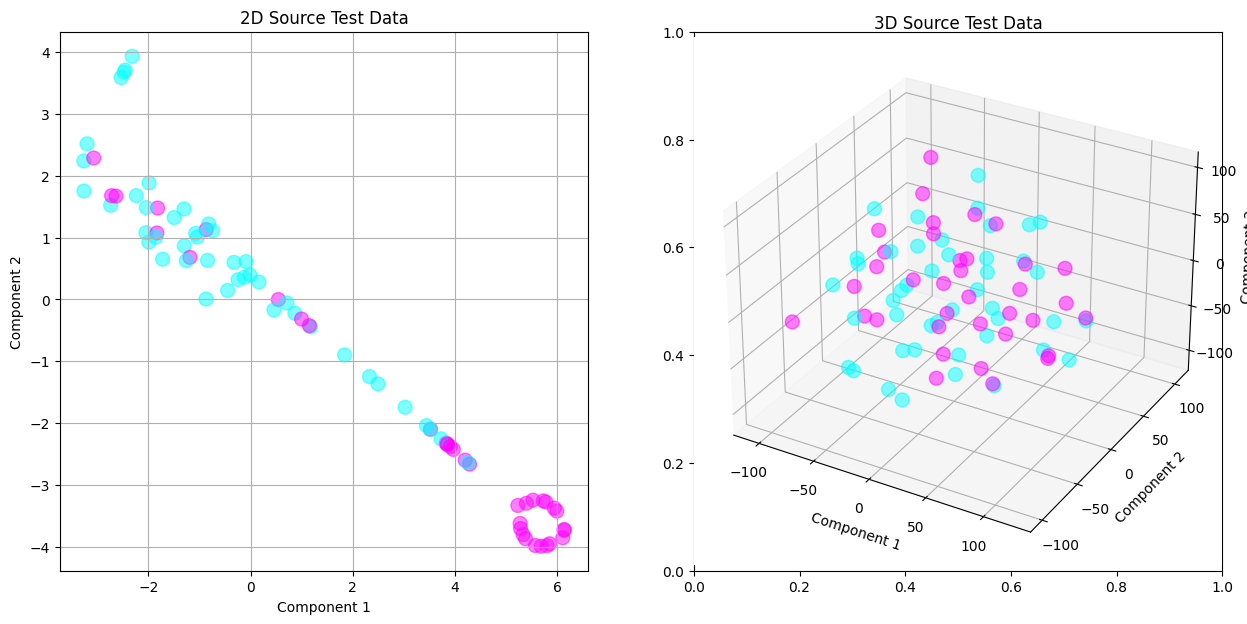

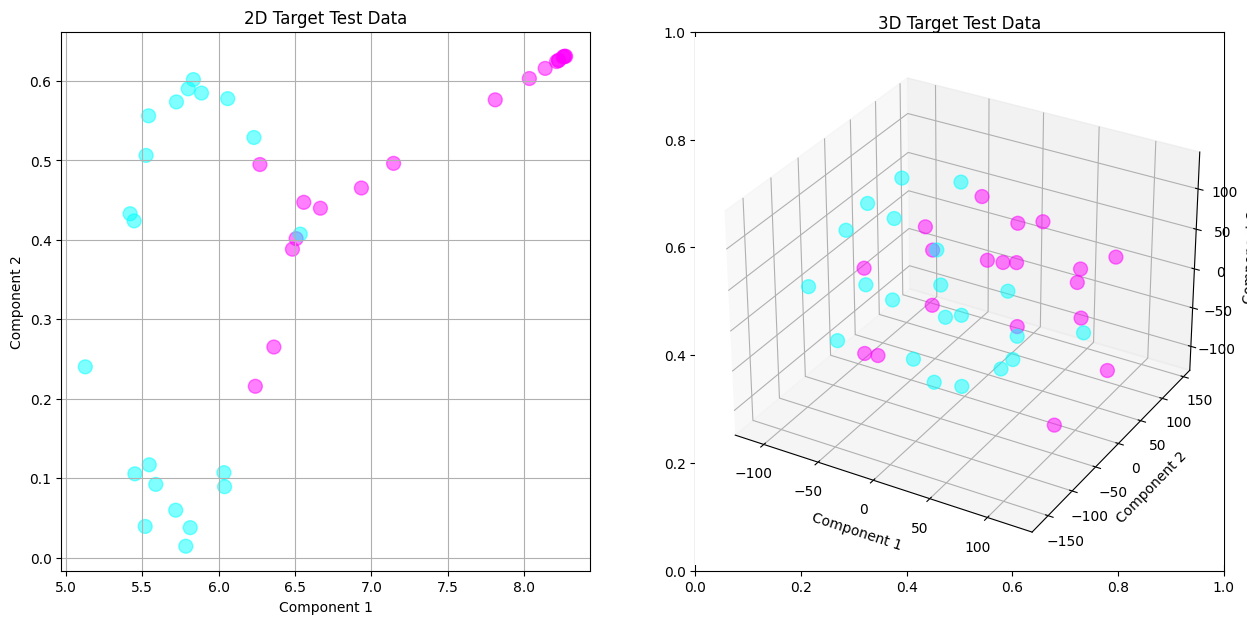

In [ ]:
# Source
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(
    stf2[:,0],
    stf2[:,1],
    c = y_s_test,
    cmap = 'cool',
    s =  100,
    alpha = .5
)
ax1.set_title('2D Source Test Data')
ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')
ax1.grid()

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(
    stf3[:, 0],
    stf3[:, 1],
    stf3[:, 2],
    c = y_s_test,
    cmap = 'cool',
    s = 100,
    alpha =.5
)
ax2.set_title('3D Source Test Data')
ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')
ax2.set_zlabel('Component 3')

plt.savefig('source_test.png')

# Target
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.scatter(
    ttf2[:,0],
    ttf2[:,1],
    c = y_t_test,
    cmap = 'cool',
    s =  100,
    alpha = .5
)
ax1.set_title('2D Target Test Data')
ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')
ax1.grid()

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(
    ttf3[:, 0],
    ttf3[:, 1],
    ttf3[:, 2],
    c = y_t_test,
    cmap = 'cool',
    s = 100,
    alpha =.5
)
ax2.set_title('3D Target Test Data')
ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')
ax2.set_zlabel('Component 3')

plt.savefig('target_test.png')

#